# Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit,minimize
from glob import glob
from scipy.interpolate import InterpolatedUnivariateSpline
import re
import os

In [2]:
doorbbary=True   # Barycentric correction of pulsar orbit
dolocalbary=True # Barycentric correction of spacecraft orbit; requires HEASOFT barycorr
if doorbbary:
    SOURCENAME='herx1' # For GBM PSR data 
else:
    NU=0.8079475 # guess for PSR frequency
    NUDOT=0
OBSID='02004001'
MODF='FTP/caldb/data/ixpe/gpd/cpf/modfact/ixpe_d%d_20170101_mfact_02.fits'

# Setup  Directories

In [3]:
os.system('[ -d output ] || mkdir output ; [ -d figures ] || mkdir figures ; [ -d data ] || mkdir data')

0

# Setup Data and Modulation Files in Data Directory

In [4]:
DIRECTORY='FTP/ixpe/data/obs/%s//%s/' % (OBSID[0:2],OBSID)
SCIHEADER='/home/idies/workspace/headata'

## Set up Raw Data Files

In [5]:
rawdatafilelist=sorted(glob('data/ixpe*_det?_evt2_*.fits*'))
if len(rawdatafilelist)<3:
    print('get data files')
    # if you are on sciserver create symbolic links to the data, otherwise download the manifest and then files
    if os.path.isdir('%s/%s/event_l2/' % (SCIHEADER,DIRECTORY)):
        os.system('cd data ; for ii in %s/%s/event_l2/*.fits.gz ; do ln -s $ii ; done' % (SCIHEADER,DIRECTORY))
    else:
        os.system('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/event_l2/' % DIRECTORY)
        with open('data/index.html','r') as f:
            for line in f:
                res=re.search('href="ixpe.+fits\.gz"',line)
                if res is not None:
                    os.system('cd data  ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/event_l2/%s' % (DIRECTORY,line[res.start()+6:res.end()-1]))
        os.remove('data/index.html')
    rawdatafilelist=sorted(glob('data/ixpe*_det?_evt2_*.fits*'))

## Perform Spacecraft barycentering

In [6]:
if dolocalbary:
    orbfilelist=sorted(glob('data/ixpe*orb_*fits*'))
    if len(orbfilelist)<1:
        print('get orb files')
        # if you are on sciserver create symbolic links to the data, otherwise download the manifest and then files
        if os.path.isdir('%s/%s/hk/' % (SCIHEADER,DIRECTORY)):
            os.system('cd data ; for ii in %s/%s/hk/*orb*.fits.gz ; do ln -s $ii ; done' % (SCIHEADER,DIRECTORY))
        else:
            os.system('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/hk/' % DIRECTORY)
            with open('data/index.html','r') as f:
                for line in f:
                    res=re.search('href="ixpe.+orb.+fits\.gz"',line)
                    if res is not None:
                        os.system('cd data  ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/hk/%s' % (DIRECTORY,line[res.start()+6:res.end()-1]))
            os.remove('data/index.html')
    orbfilelist=sorted(glob('data/ixpe*orb_*fits*'))
    datafilelist=sorted(glob('data/ixpe*_det?_evt2_*_bary.fits*'))
    if len(datafilelist)<3:
        print('perform barycentric correction')
        for ff in rawdatafilelist:
            os.system('HEADASNOQUERY= HEADASPROMPT=/dev/null barycorr %s %s %s' % (ff,ff.replace('.fits.gz','_bary.fits.gz'),','.join(orbfilelist)))
    datafilelist=sorted(glob('data/ixpe*_det?_evt2_*_bary.fits*'))
else:
    datafilelist=rawdatafilelist
#/home/idies/workspace/headata/FTP/caldb/data
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01001899/event_l2/ixpe01001899_det1_evt2_v02.fits.gz
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01001899/hk/
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/02//02003801/event_l2/

## Setup modulation files

In [7]:
modfilelist=sorted(glob('data/ixpe*_mfact*.fits*'))
if len(modfilelist)<3:
    print('get modf files')
    # if you are on sciserver create symbolic links to the data, otherwise download the files
    if os.path.exists('%s/%s' % (SCIHEADER,MODF.replace('%d','1'))):
        os.system('cd data ; for ii in %s/%s ; do ln -s $ii ; done' % (SCIHEADER,MODF.replace('%d','?')))
    else:
        for i in range(1,4):
            os.system((('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s' % MODF)) % i)
    modfilelist=sorted(glob('data/ixpe*_mfact*.fits*'))


# Definition of RVM

In [8]:
def angfunk(alpha,beta,phase):
    tanhalfC=np.tan(phase*np.pi)
    halfamb=np.radians(alpha-beta)/2
    halfapb=np.radians(alpha+beta)/2
    halfAmB=np.arctan2(np.sin(halfamb),np.sin(halfapb)*tanhalfC)
    halfApB=np.arctan2(np.cos(halfamb),np.cos(halfapb)*tanhalfC)
    return (halfAmB-halfApB)


# Load Data and Modulation Fraction

In [9]:
nphotondu=np.zeros(4).astype(int)
for i,f in enumerate(datafilelist): 
    print(i,f)
    with fits.open(modfilelist[i]) as hdu:
        modlist=hdu[1].data['SPECRESP']
    with fits.open(f) as hdu:
        # hdu[1].data['PI']=pislope[i]*hdu[1].data['PI']+pioffset[i]
        if (i==0):
            MJDREFI=hdu[0].header['MJDREFI']
            MJDREFF=hdu[0].header['MJDREFF']
            LIVETIME=hdu[0].header['LIVETIME']
            evtlist=hdu[1].data
            moddata=np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])
            detector=np.full(len(hdu[1].data),i+1)
        else:
            evtlist=np.append(evtlist,hdu[1].data)
            moddata=np.concatenate((moddata,np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])))
            detector=np.concatenate((detector,np.full(len(hdu[1].data),i+1)))


0 data/ixpe02004001_det1_evt2_v01_bary.fits.gz
1 data/ixpe02004001_det2_evt2_v01_bary.fits.gz
2 data/ixpe02004001_det3_evt2_v01_bary.fits.gz


In [10]:
xc, yc=300, 300
for _i in range(5):
    rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
    ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<50) 
    xc,yc=np.mean(evtlist['X'][ok]),np.mean(evtlist['Y'][ok])
    print(xc,yc)
rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<20) 
back=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr>30)  & (rr<50)
evtback=evtlist[back]
evtlist=evtlist[ok]
modback=moddata[back]
moddata=moddata[ok]
detback=detector[back]
detector=detector[ok]


301.63663 286.92328
301.67972 286.5232
301.68073 286.51266
301.68088 286.51227
301.68088 286.51227


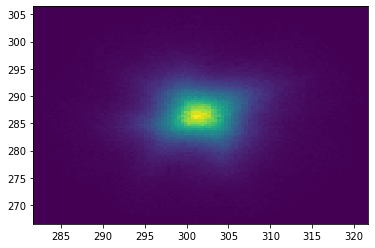

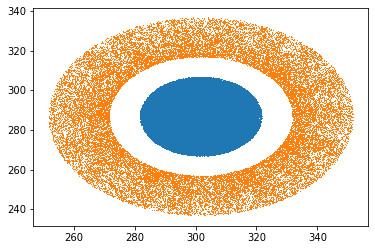

In [11]:
plt.hist2d(evtlist['X'],evtlist['Y'],bins=100)
plt.show()
plt.plot(evtlist['X'],evtlist['Y'],',')
plt.plot(evtback['X'],evtback['Y'],',')

In [12]:
len(evtback)/len(evtlist)/4

0.007906091241875133

In [13]:
pispec=np.histogram(evtlist['PI'],bins=150)[0]
np.save('output/pispec',pispec)

In [14]:
backpispec=np.histogram(evtback['PI'],bins=150)[0]*20**2/(50**2-30**2)
np.save('output/backpispec',backpispec)

In [15]:
for i in range(1,4):
    _q,_u=np.mean((evtlist['Q']/moddata)[detector==i]),np.mean((evtlist['U']/moddata)[detector==i])
    print(i,_q,_u,np.hypot(_q,_u))

1 -0.02140812673438465 0.0736804327826248 0.0767275313385643
2 -0.0024519747801810448 0.08642464985447634 0.08645942564458477
3 -0.01345737110357219 0.08338576005084894 0.08446470159940787


# Barycentring with GBM Orbital Elements

In [16]:

if doorbbary:
    os.system('[ -f %s.fits.gz ] || curl https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/%s.fits.gz --output %s.fits.gz' % (SOURCENAME,SOURCENAME,SOURCENAME))
    with fits.open('%s.fits.gz' % SOURCENAME)  as hdu:
        orbitdata=hdu['Orbital Elements'].data
        spindata=hdu['PSR_HIST'].data
    day=3600*24
    TPIOVER2O=orbitdata['BINARYEPOCH']-2400000.5
    PORB=orbitdata['PBINARY']*day
    PORBDOT=orbitdata['PBDOT']
    ECCENTRICITY=orbitdata['ECCENTRICITY']
    OMEGA=orbitdata['PERIAPSE']
    ASINIOVERC=orbitdata['AXSINI']
    NUORB=1/PORB
    NUORBDOT=-1/PORB/PORB*PORBDOT
    met0=evtlist['TIME'].min()
    MJDSTART=MJDREFF+MJDREFI+met0/day
    NU=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FREQUENCY'])
    NUDOT=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FDOT'])
    TREFNU=MJDSTART
    torb=((MJDREFF+MJDREFI)+evtlist['TIME']/day-TPIOVER2O)*day
    phaseorb=(0.25+torb*(NUORB+torb*NUORBDOT/2))                    
    orbtime=ASINIOVERC*((np.sin(2*np.pi*phaseorb)-np.sin(np.pi/2))-
                    0.5*ECCENTRICITY*(np.sin(4*np.pi*phaseorb-np.radians(OMEGA))-
                                      np.sin(np.pi/2-np.radians(OMEGA))))
    deltat=evtlist['TIME']-orbtime-met0
    freqtst=NU
    if NUDOT==0:
        _ii=spindata['BARYTIME']>59000
        nufunk=InterpolatedUnivariateSpline(spindata['BARYTIME'][_ii],spindata['FREQUENCY'][_ii],k=2)
        nudd=nufunk.derivatives(MJDSTART)
        NU=nudd[0]
        NUDOT=nudd[1]/day
        NUDDOT=nudd[2]/day/day
    else:
        NUDDOT=0

else:
    deltat=evtlist['TIME']-evtlist['TIME'].min()
phdata=np.mod(deltat*(NU+0*0.5*deltat*(NUDOT*deltat*NUDDOT*0.3333333)),1)

In [17]:
MJDSTART,NU,NUDOT,freqtst,LIVETIME

(59978.81988397932,
 0.8079475039414423,
 4.143139582617706e-15,
 0.8079474850576043,
 244566.410694)

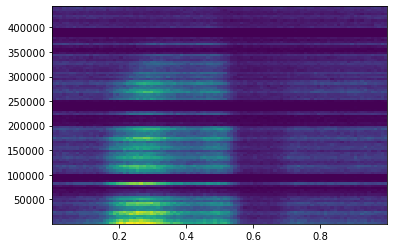

In [18]:
bindata=plt.hist2d(phdata,deltat,bins=100)

In [19]:
NU,deltat.min()

(0.8079475039414423, 21.44425031542778)

0.6686771538022659


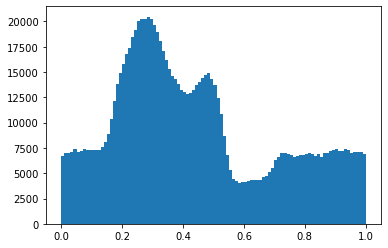

In [20]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

In [21]:
np.argmax(toton[0])

28

In [22]:
np.savez('output/toton',toton,dtype=object)

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Unbinned Likelihood Analysis

In [23]:
qdata=evtlist['Q']*moddata
udata=evtlist['U']*moddata

def maxlikephase(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikephaseok(param,_phb,_qd,_ud):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[_phb]*_qd+uloc[_phb]*_ud))))


def maxlikephasequ(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.tanh(param[2*_i])
        uloc[_i]=np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikefixed(param):
    qloc=param[0]
    uloc=param[1]
    norm=np.hypot(qloc,uloc)
    if norm>1:
        qloc/=norm
        uloc/=norm
    
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

def maxlikerotation(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    _res=-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata)))
    # print(_res,param)
    return _res
def maxlikerotation_rand(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    return(-np.sum(np.log(1+0.5*(qloc*qrand+uloc*urand))))
def maxlikerotation2(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))
def maxlikerotation2_ok(param,_phd,_qd,_ud):
    ang=angfunk(param[1],param[2],_phd-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(_phd-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8]) 
    return(-np.sum(np.log(1+0.5*(qloc*_qd+uloc*_ud))))
def maxlikerotation2frac(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3]+param[4]*tdata)
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

In [24]:
np.savetxt('output/photondata.txt',[phdata,qdata,udata])

In [25]:
ppp_fixed=minimize(maxlikefixed,np.random.normal(size=2)*np.array([0.3,0.3]),method='Nelder-Mead')
ppp_fixed

 final_simplex: (array([[-0.00800552,  0.08049365],
       [-0.00793784,  0.08048935],
       [-0.00795446,  0.08043259]]), array([-153.55928255, -153.559238  , -153.55922261]))
           fun: -153.55928255076324
       message: 'Optimization terminated successfully.'
          nfev: 74
           nit: 39
        status: 0
       success: True
             x: array([-0.00800552,  0.08049365])

In [26]:
ppp_rot=minimize(maxlikerotation2,np.random.normal(size=5)*np.array([np.hypot(ppp_fixed.x[0],ppp_fixed.x[1]),50,50,90,1]),method='Nelder-Mead')
if (ppp_rot.x[0]<0):
    ppp_rot.x[0]*=-1
    ppp_rot.x[3]+=90
ppp_rot

 final_simplex: (array([[ 9.44709758e-02, -3.77613153e-02, -1.49366449e-02,
        -1.33725530e+02, -1.54901793e+00],
       [ 9.44683730e-02, -3.90429298e-02, -1.54440673e-02,
        -1.33726005e+02, -1.54902454e+00],
       [ 9.44669200e-02, -4.04092414e-02, -1.59842672e-02,
        -1.33725532e+02, -1.54901630e+00],
       [ 9.44685216e-02, -4.05732210e-02, -1.60497095e-02,
        -1.33725875e+02, -1.54902079e+00],
       [ 9.44679527e-02, -4.33447702e-02, -1.71456188e-02,
        -1.33725673e+02, -1.54902298e+00],
       [ 9.44685873e-02, -4.12380320e-02, -1.63120736e-02,
        -1.33726146e+02, -1.54902059e+00]]), array([-208.46474104, -208.46474103, -208.46474089, -208.46474088,
       -208.46474085, -208.46474084]))
           fun: -208.46474103930012
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1000
           nit: 625
        status: 1
       success: False
             x: array([ 9.44709758e-02, -3.77613153e-02, -1.49366449e-

In [27]:
ppp_rot2=minimize(maxlikerotation2,np.concatenate((ppp_rot.x,np.random.normal(size=2))),method='Nelder-Mead')
ppp_rot2

 final_simplex: (array([[ 1.06480205e-01, -4.29700507e-02, -1.48942228e-02,
        -1.33950441e+02, -1.53612007e+00,  4.19322494e-01,
        -1.68557407e-01],
       [ 1.06480282e-01, -4.29700679e-02, -1.48941838e-02,
        -1.33950383e+02, -1.53612000e+00,  4.19322795e-01,
        -1.68558019e-01],
       [ 1.06480209e-01, -4.29701284e-02, -1.48941663e-02,
        -1.33950445e+02, -1.53612077e+00,  4.19323059e-01,
        -1.68557783e-01],
       [ 1.06480265e-01, -4.29700954e-02, -1.48941734e-02,
        -1.33950496e+02, -1.53612039e+00,  4.19324423e-01,
        -1.68558408e-01],
       [ 1.06480393e-01, -4.29700213e-02, -1.48941285e-02,
        -1.33950394e+02, -1.53612034e+00,  4.19324575e-01,
        -1.68557165e-01],
       [ 1.06480352e-01, -4.29700086e-02, -1.48942176e-02,
        -1.33950392e+02, -1.53612105e+00,  4.19323828e-01,
        -1.68557979e-01],
       [ 1.06480520e-01, -4.29700829e-02, -1.48941897e-02,
        -1.33950469e+02, -1.53612061e+00,  4.19321562e-01,
 

In [28]:
ppp_rot=minimize(maxlikerotation2,ppp_rot2.x[0:-2],method='Nelder-Mead')
ppp_rot

 final_simplex: (array([[ 9.44683560e-02, -4.18684393e-02, -1.65613382e-02,
        -1.33725357e+02, -1.54902260e+00],
       [ 9.44685401e-02, -4.18681799e-02, -1.65614048e-02,
        -1.33725423e+02, -1.54902312e+00],
       [ 9.44685632e-02, -4.18682609e-02, -1.65613675e-02,
        -1.33725445e+02, -1.54902261e+00],
       [ 9.44682137e-02, -4.18683261e-02, -1.65614359e-02,
        -1.33725404e+02, -1.54902254e+00],
       [ 9.44683376e-02, -4.18682129e-02, -1.65612782e-02,
        -1.33725392e+02, -1.54902115e+00],
       [ 9.44679953e-02, -4.18684339e-02, -1.65613788e-02,
        -1.33725366e+02, -1.54902248e+00]]), array([-208.46474099, -208.46474099, -208.46474099, -208.46474099,
       -208.46474099, -208.46474099]))
           fun: -208.46474099131513
       message: 'Optimization terminated successfully.'
          nfev: 189
           nit: 104
        status: 0
       success: True
             x: array([ 9.44683560e-02, -4.18684393e-02, -1.65613382e-02, -1.33725357e+02,
 

# Binned Analysis

In [29]:
qloc=np.zeros(14)
uloc=np.zeros(14)
phbin=(phdata//(1/14.0)).astype(int)
ppp_phase=minimize(maxlikephase,np.random.uniform(size=28))
ppp_phase_err=np.diag(ppp_phase.hess_inv)**0.5  
tt=np.histogram(phdata,bins=14)[0]
phlist=np.linspace(1./28,27./28,14)


In [30]:
ppp_phasequ=minimize(maxlikephasequ,np.random.uniform(size=28))
ppp_phasequ_err=np.diag(ppp_phasequ.hess_inv)**.5

In [31]:
phlist,len(ppp_phasequ.x),len(np.diag(ppp_phasequ.hess_inv)),len(tt-0)

(array([0.03571429, 0.10714286, 0.17857143, 0.25      , 0.32142857,
        0.39285714, 0.46428571, 0.53571429, 0.60714286, 0.67857143,
        0.75      , 0.82142857, 0.89285714, 0.96428571]),
 28,
 28,
 14)

In [32]:
tt=np.histogram(phdata,bins=14)[0]
phlist=np.linspace(1./28,27./28,14)
with open('output/QU_phase.dat','w') as f:
    print('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts')
    f.write('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts\n')

    for r in zip(phlist,np.tanh(ppp_phasequ.x[::2]),np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,
                 np.tanh(ppp_phasequ.x[1::2]),np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,tt):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Phase        Q/I       EQ/I        U/I       EU/I     Counts
 0.0357143  0.0428778  0.0205473   0.186143  0.0213772      50474 
  0.107143 0.00464067  0.0209698  0.0981155  0.0204109      52516 
  0.178571 -0.0261179   0.016329  0.0377245  0.0159812      88713 
      0.25 -0.0817189  0.0124544 0.00711005    0.01337     137108 
  0.321429 -0.0669715  0.0131076  0.0582348  0.0129167     130033 
  0.392857 -0.0195726  0.0160935   0.084321  0.0143627      97009 
  0.464286  0.0106664  0.0175752  0.0569486  0.0156542     101232 
  0.535714  0.0259964  0.0181125  0.0462874  0.0187823      62833 
  0.607143  0.0944383  0.0273639   0.139734  0.0255099      29923 
  0.678571  0.0542189  0.0244731   0.107398  0.0246466      36556 
      0.75  0.0776928  0.0223456   0.127444  0.0222653      48800 
  0.821429  0.0139313   0.022976   0.164831  0.0216684      48891 
  0.892857  0.0185637  0.0207594   0.128696  0.0207479      51126 
  0.964286  0.0127976  0.0200154    0.13525  0.0195772      509

In [33]:
with open('output/pol_phase.dat','w') as f:
    print('#    Phase         PD        EPD         PA        EPA     Counts')
    f.write('#    Phase         PD        EPD         PA        EPA     Counts\n')
    for r in zip((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2]),180),
        np.degrees(ppp_phase_err[::2]),tt):
        print('%10g '*6 %r)
        f.write(('%10g '*6 %r)+'\n')
        

#    Phase         PD        EPD         PA        EPA     Counts
 0.0357143   0.191017  0.0209484    38.5141     3.3566      50474 
  0.107143  0.0982251  0.0198804     43.646    10.6486      52516 
  0.178571  0.0458834  0.0155114     62.348    13.7882      88713 
      0.25  0.0820276  0.0130134    87.5137    3.50334     137108 
  0.321429  0.0887495  0.0128376    69.4958    4.54815     130033 
  0.392857  0.0865628  0.0144624     51.534    4.78293      97009 
  0.464286  0.0579389  0.0155428    39.6958    4.07438     101232 
  0.535714   0.053088  0.0252015    30.3401    4.37934      62833 
  0.607143   0.168654  0.0325911    27.9737     9.4833      29923 
  0.678571   0.120308  0.0238998    31.6068    3.59178      36556 
      0.75   0.149259  0.0210001    29.3163    6.17261      48800 
  0.821429   0.165418  0.0278412    42.5844    3.15033      48891 
  0.892857   0.130028  0.0203621     40.896    9.25027      51126 
  0.964286   0.135854  0.0208199    42.2973     3.1185      509

Text(0, 0.5, 'U/I')

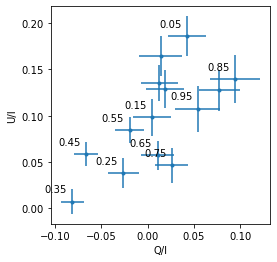

In [34]:
#plt.figure(figsize=(6,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),yerr=np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),np.linspace(0.05,0.95,10)):
    plt.text(_xx-3e-2,_yy+1e-2,'%.2f' % _tt)
plt.xlabel('Q/I')
plt.ylabel('U/I')

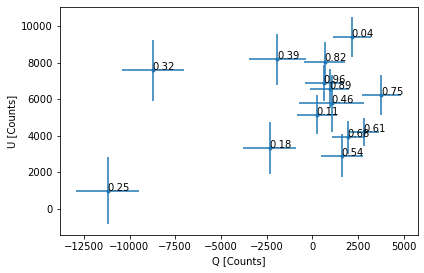

In [35]:
#plt.figure(figsize=(7,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,yerr=tt*np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=tt*np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt,_qq in zip(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,phlist,tt):
    plt.text(_xx-3e+1,_yy+1e+1,'%.2f' % (_tt))
param=ppp_rot2.x
ang=angfunk(param[1],param[2],phlist-param[4])+np.radians(param[3])
polfrac=np.tanh(param[0])
if (len(param)>5):
    polfrac*=(1+param[5]*np.cos(2*np.pi*(phlist-param[6])))

qloc=np.cos(2*ang)*polfrac*60000
uloc=np.sin(2*ang)*polfrac*60000
#plt.plot(qloc,uloc)  
#plt.xlim(-18000,5000)
#plt.ylim(0,12000)
#plt.ylim(-0.1,0.3)
plt.xlabel('Q [Counts]')
plt.ylabel('U [Counts]')
plt.tight_layout()
plt.savefig('figures/QU.pdf')

# Plots

In [36]:
def plottwo(x,y,yerr=None,fmt=None,ax=None,**kwargs):
    _x=np.concatenate((x,x+1))
    _y=np.concatenate((y,y))
    if fmt is None:
        fmt='.'
    if ax is None:
        if yerr is None:
            plt.plot(_x,_y,xerr=(_x[1]-_x[0])/2,fmt=fmt,**kwargs)
        else:
            _yerr=np.concatenate((yerr,yerr))
            plt.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt,**kwargs)
    else:
        if yerr is None:
            ax.plot(_x,_y,xerr=(_x[1]-_x[0])/2,fmt=fmt,**kwargs)
        else:
            _yerr=np.concatenate((yerr,yerr))
            ax.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt,**kwargs)



In [37]:
def cfunk(p,a,b,c):
    return(a*np.cos((p-b)*2*np.pi)+c)

cfit=curve_fit(cfunk,0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],sigma=(toton[0])**0.5)
pfit=curve_fit(cfunk,(np.arange(len(ppp_phase.x)//2)+0.5)/10,100*np.abs(np.tanh(ppp_phase.x[1::2])),sigma=100*ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2)

0.6686771538022659


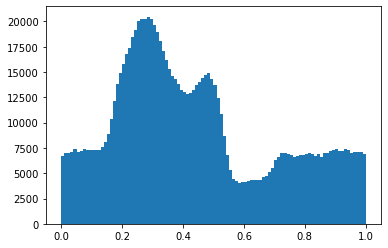

In [38]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

0.6686771538022659 0.5040216248236846


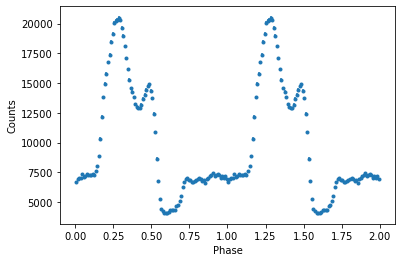

In [39]:

_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.')
#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()),cfit[0][0]/cfit[0][2])
plt.savefig('figures/intensity.pdf')

0.11235812308505995 0.007941361731190177


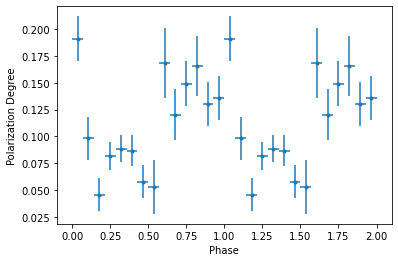

In [40]:
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
#plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))))
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
plt.savefig('figures/polar-deg.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      179.957
Beta:                       -0.0148942
Mean Polarization Fraction: 0.10608
Ampl Polarization Fraction: 0.0444816
Peak Polarization Fraction: 0.831443
Pole across Line of Sight:  0.96388
Peak Flux:                  0.28505


Alpha:                      179.958
Beta:                       -0.0165613
Mean Polarization Fraction: 0.0941883
Pole across Line of Sight:  0.950977
Peak Flux:                  0.28505



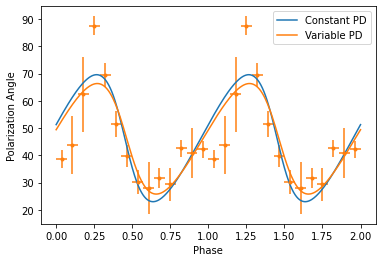

In [41]:
shift=0


plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),c='tab:orange')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Ampl Polarization Fraction: %g
Peak Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % ((ppp_rot2.x[1]%180,ppp_rot2.x[2])+tuple(np.mod(np.array([np.abs(np.tanh(ppp_rot2.x[0])),np.abs(ppp_rot2.x[5]*np.tanh(ppp_rot2.x[0])),
                                                            ppp_rot2.x[6],
                                                            ppp_rot2.x[4]+(0 if ppp_rot2.x[2]>0 else 0.5),
                                                            (cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5)]),1))))
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))
if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')

if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')

#plt.plot(_ph,np.degrees(np.mod((angfunk(medvalues1[1],medvalues1[2],_ph-medvalues1[4])+np.radians(medvalues1[3]-shift)),np.pi))+shift,c='tab:blue',label='MCMC1')
#plt.plot(_ph,np.degrees(np.mod((angfunk(medvalues2[1],medvalues2[2],_ph-medvalues2[4])+np.radians(medvalues2[3]-shift)),np.pi))+shift,c='tab:orange',label='MCMC2')

#plt.plot(_ph,np.degrees(np.mod((angfunk(60.8,16.8,_ph-0.272)+np.radians(45.2-shift)),np.pi))+shift,label='MCMC')
    
#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle.pdf')

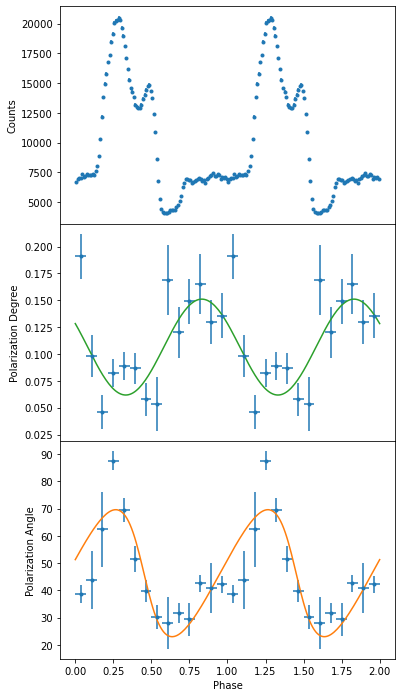

In [42]:
shift=0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(6,12))
_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.',ax1)
ax1.set_ylabel('Counts')
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.',ax2)
ax2.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))),c='tab:green')
ax2.set_ylabel('Polarization Degree')
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.',ax3)
ax3.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift)


ax3.set_ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/triple.pdf')

# Energy Dependence

In [43]:
pibin=np.clip(((evtlist['PI']-50)//25).astype(int),0,4)
def maxlikeenergy(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[2*pibin])*qrot+np.tanh(param[2*pibin+1])*urot))))
def maxlikeenergy2(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[pibin])*qrot))))


In [44]:
angdata=angfunk( ppp_rot.x[1],  ppp_rot.x[2], phdata-ppp_rot.x[4])+np.radians(ppp_rot.x[3])

sangdata=np.sin(2*angdata)
cangdata=np.cos(2*angdata)
urot=evtlist['U']*cangdata-evtlist['Q']*sangdata
qrot=evtlist['U']*sangdata+evtlist['Q']*cangdata
um,qm=np.mean(urot/moddata),np.mean(qrot/moddata)
print(um,qm,np.hypot(um,qm),np.std(qrot/moddata)/len(qrot)**0.5,np.std(qrot)/np.mean(moddata)/len(qrot)**0.5)
urot*=moddata
qrot*=moddata

0.0020060404956114644 0.09584386956135163 0.09586486077267008 0.005793704833153907 0.004842637267803286


In [45]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=5)-0.5)

In [46]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=10)-0.5)

Text(0, 0.5, 'U/I')

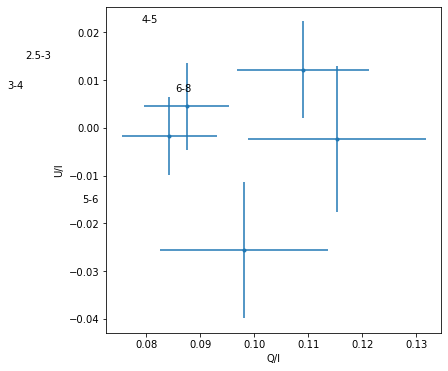

In [47]:
plt.figure(figsize=(6,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),['2.5-3','3-4','4-5','5-6','6-8']):
    plt.text(_xx-3e-2,_yy+1e-2,_tt)
#plt.xlim(-0.29,0.29)
#plt.ylim(-0.29,0.29)
plt.xlabel('Q/I')
plt.ylabel('U/I')

Text(0, 0.5, 'Q/I')

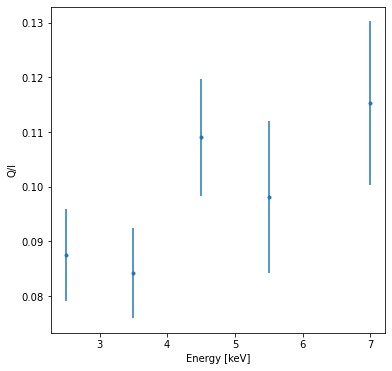

In [48]:
plt.figure(figsize=(6,6))
_xxx=[2.5,3.5,4.5,5.5,7]
plt.errorbar(_xxx,np.tanh(ppp_spec_deg.x),yerr=np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2,fmt='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')

# Bin optimization

In [49]:
_ii=np.argsort(evtlist['PI'])
pisort=evtlist['PI'][_ii]
modsort=moddata[_ii]

In [50]:
modcum=np.cumsum(modsort)
def mdpfunk(imin,imax):
    return(4.29/((modcum[imax]-modcum[imin])/(imax-imin))/(imax-imin)**0.5)
def mdppi(pimin,pimax):
    _imin=np.interp(pimin,pisort,range(len(pisort))).astype(int)
    _imax=np.interp(pimax,pisort,range(len(pisort))).astype(int)

    return mdpfunk(_imin,_imax)

In [51]:
modscum=np.cumsum(modsort**2)

In [52]:
plist=np.interp(np.linspace(0,1,70),modscum/modscum[-1],np.arange(len(modcum))).astype(int)
plist

array([     0,  65619, 117275, 160490, 197808, 231182, 261210, 288645,
       314123, 337919, 360262, 381389, 401399, 420424, 438612, 456104,
       472904, 489094, 504783, 519978, 534720, 549037, 562927, 576410,
       589574, 602391, 614955, 627265, 639289, 651150, 662736, 674082,
       685187, 696119, 706926, 717485, 727882, 738139, 748183, 758111,
       767851, 777528, 786953, 796322, 805499, 814602, 823543, 832316,
       840995, 849524, 857827, 866130, 874246, 882171, 890025, 897606,
       905130, 912403, 919576, 926550, 933315, 939928, 946351, 952576,
       958605, 964449, 970115, 975629, 980979, 986169])

In [53]:
for ii in range(len(plist)-1):
    _imin=plist[ii]
    _imax=plist[ii+1]
    _pmin,_pmax=pisort[_imin],pisort[_imax]
    # print(ii,_pmin,_pmax,_pmin/25,_pmax/25,mdpfunk(plist[ii],plist[ii+1]))

In [54]:
pilist=np.concatenate((pisort[plist[0:65:5]],pisort[plist[65:]]))
elist=pilist/25

In [55]:
pibin=np.digitize(evtlist['PI'],pilist)-1
pibin.min(),pibin.max()

(0, 17)

In [56]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=pibin.max()+1)-0.5)

In [57]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=2*pibin.max()+2)-0.5)

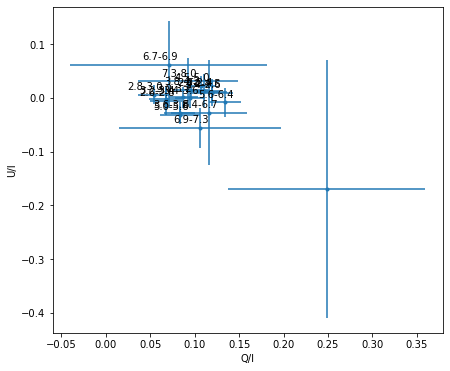

In [58]:
plt.figure(figsize=(7,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_e0,_e1 in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),elist[:-1],elist[1:]):
    plt.text(_xx-3e-2,_yy+1e-2,'%.1f-%.1f' % (_e0,_e1))
#plt.xlim(-0.4,0.3)
#plt.ylim(-0.3,0.3)
plt.xlabel('Q/I')
plt.ylabel('U/I')
plt.savefig('figures/QU-energy_v1.pdf')

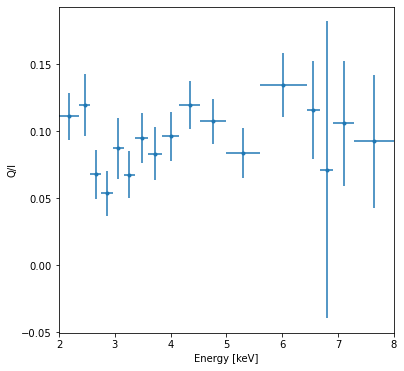

In [59]:
plt.figure(figsize=(6,6))

plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             yerr=(np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.')
plt.xlim(2,8)

plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')
plt.savefig('figures/polar-energy.pdf')
np.save('output/qoveri',[0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             0.5*(-elist[:-1]+elist[1:])])

In [60]:
with open('output/poldeg_energy.dat','w') as f:
    print('#     Emid        Q/I       EQ/I   DeltaE/2')
    f.write('#     Emid        Q/I       EQ/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
                 (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
                 0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*4) % r)
        f.write((('%10g '*4) % r)+'\n')

#     Emid        Q/I       EQ/I   DeltaE/2
      2.18    0.11089  0.0175013       0.18 
      2.46   0.119648  0.0229664        0.1 
      2.66  0.0677209  0.0180133        0.1 
      2.86   0.053727  0.0168314        0.1 
      3.06  0.0871951  0.0225665        0.1 
      3.26  0.0675895  0.0174285        0.1 
      3.48  0.0947418  0.0188528       0.12 
      3.72  0.0830283   0.019801       0.12 
         4  0.0959807  0.0185043       0.16 
      4.34   0.119446  0.0176444       0.18 
      4.76   0.107369  0.0167885       0.24 
       5.3  0.0836069  0.0185973        0.3 
      6.02   0.134283  0.0238329       0.42 
      6.56   0.115942  0.0365134       0.12 
       6.8  0.0712052   0.110471       0.12 
       7.1   0.105707  0.0468743       0.18 
      7.64  0.0922356  0.0496681       0.36 


In [61]:
with open('output/QU_energy.dat','w') as f:
    print('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2')
    f.write('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x[::2]),np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,
                 np.tanh(ppp_spec_qu.x[1::2]),np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,
                0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2
      2.18   0.110869  0.0172425  0.0130767  0.0305407       0.18 
      2.46   0.119621  0.0240529 0.00964676  0.0252596        0.1 
      2.66  0.0677126  0.0184015 -0.00630817  0.0265069        0.1 
      2.86  0.0537287  0.0174096 0.00589821  0.0170906        0.1 
      3.06  0.0871913  0.0161769 0.00088447  0.0193299        0.1 
      3.26  0.0675844  0.0185848 -0.0021946  0.0194568        0.1 
      3.48  0.0947421  0.0174105 -0.00118454  0.0178734       0.12 
      3.72  0.0831774  0.0172639 -0.0281121  0.0194774       0.12 
         4  0.0959645  0.0190012  0.0142667  0.0188117       0.16 
      4.34   0.119446  0.0174952  0.0108495    0.01983       0.18 
      4.76   0.107436  0.0164565  0.0224453  0.0172896       0.24 
       5.3  0.0835892  0.0223554 -0.0323856   0.016486        0.3 
      6.02   0.134262  0.0180437 -0.00878858  0.0263735       0.42 
      6.56   0.116144  0.0433009  -0.027627  0.0971115      

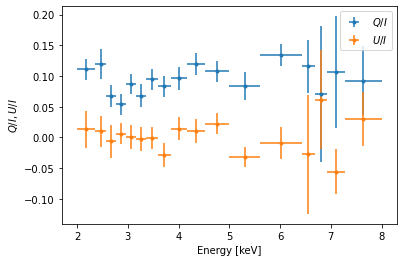

In [62]:
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[:-2:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[:-2:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$Q/I$')
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[1:-1:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[1:-1:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$U/I$')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$Q/I, U/I$')
plt.savefig('figures/QU-energy_v2.pdf')